<a href="https://colab.research.google.com/github/sayid-alt/mymachine-learning/blob/main/recommender-system/movielens_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [1]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt
import warnings
warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
alt.data_transformers.enable('default', max_rows=None)

alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
# alt.renderers.enable('colab')

# **DOWNLOAD MOVIELENS DATA**

In [4]:
print('Downloading movielens data...')
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", 'movielens.zip')
zip_ref = zipfile.ZipFile('movielens.zip', 'r')
zip_ref.extractall()
print('Done.')
print(zip_ref.read('ml-100k/u.info'))

Done.
b'943 users\n1682 items\n100000 ratings\n'


# **LOAD DATASETS**

In [5]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1'
)


In [6]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
 5   genre_unknown       1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children            1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

In [8]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         100000 non-null  int64
 1   movie_id        100000 non-null  int64
 2   rating          100000 non-null  int64
 3   unix_timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [10]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [12]:
print('Jumlah data film: ', len(movies.movie_id.unique()))
print('Jumlah data pengunjung: ', len(users.user_id.unique()))
print('Jumlah data penayangan: ', len(ratings.user_id))


Jumlah data film:  1682
Jumlah data pengunjung:  943
Jumlah data penayangan:  100000


In [13]:
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))


In [14]:
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [15]:
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)

  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)

  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])
  ]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])
  ]

mark_genres(movies, genre_cols)

In [16]:
pd.concat([movies['all_genres'], movies['genre']], axis=1)

,all_genres,genre
0,Animation-Children-Comedy,Children
1,Action-Adventure-Thriller,Adventure
2,Thriller,Thriller
3,Action-Comedy-Drama,Action
4,Crime-Drama-Thriller,Thriller
...,...,...
1677,Drama,Drama
1678,Romance-Thriller,Thriller
1679,Drama-Romance,Romance
1680,Comedy,Comedy


In [17]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,185,301,3.0,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,1,0,0,1997,Film-Noir,Crime-Film-Noir-Mystery-Thriller,39,F,executive,00000
2,21,376,1.0,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,1994,Comedy,Children-Comedy,25,M,writer,40206
3,243,50,2.0,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,1,1,1994,Romance,Drama-Romance-War-Western,28,M,technician,80525
4,165,345,1.0,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,1997,Drama,Crime-Drama,47,M,educator,55113


# **EXPLORATION**

In [18]:
pd.options.display.max_rows=10
pd.options.display.float_format = '{:.3f}'.format

def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [19]:
users.describe(include='all')

,user_id,age,sex,occupation,zip_code
count,943,943.000,943,943,943
unique,943,NaN,2,21,795
top,0,NaN,M,student,55414
freq,1,NaN,670,196,9
mean,NaN,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,NaN,7.000,NaN,NaN,NaN
25%,NaN,25.000,NaN,NaN,NaN
50%,NaN,31.000,NaN,NaN,NaN
75%,NaN,43.000,NaN,NaN,NaN


In [20]:
# Membuat filter untuk melakukan slicing data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# Fungsi yang dapat membuat histogram dari data yang sudah difilter.
def filtered_hist(field, label, filter):
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

In [21]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating' : ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Membuat visualisasi atau chart berdasarkan jumlah rating dan rata-rata
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings
)

SchemaValidationError: `HConcatChart` has no parameter named 'selection'

Existing parameter names are:
hconcat      center     description   params    title       
autosize     config     name          resolve   transform   
background   data       padding       spacing   usermeta    
bounds       datasets                                       

See the help for `HConcatChart` to read the full description of these parameters

alt.HConcatChart(...)

In [22]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

# Menampilkan visualisasi
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)


SchemaValidationError: `HConcatChart` has no parameter named 'selection'

Existing parameter names are:
hconcat      center     description   params    title       
autosize     config     name          resolve   transform   
background   data       padding       spacing   usermeta    
bounds       datasets                                       

See the help for `HConcatChart` to read the full description of these parameters

alt.HConcatChart(...)

In [23]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x : x > 20)
 .sort_values(by='rating mean', ascending=True)
 .head(10)
 )

,title,rating count,rating mean
757,Lawnmower Man 2: Beyond Cyberspace (1996),21,1.714
456,Free Willy 3: The Rescue (1997),27,1.741
687,Leave It to Beaver (1997),44,1.841
367,Bio-Dome (1996),31,1.903
1214,Barb Wire (1996),30,1.933
742,"Crow: City of Angels, The (1996)",39,1.949
889,Mortal Kombat: Annihilation (1997),43,1.953
374,Showgirls (1995),23,1.957
1036,Grease 2 (1982),24,2.000
563,Tales from the Hood (1995),27,2.037


# **RECOMMENDER**

<img src="https://dicoding-web-img.sgp1.cdn.digitaloceanspaces.com/original/academy/dos-c556df464b8f49a1a013f375aa9bf28220240625164230.jpeg" />

In [24]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]

  return train, test

In [25]:
ratings[['user_id', 'movie_id']].values

array([['195', '241'],
       ['185', '301'],
       ['21', '376'],
       ...,
       ['275', '1089'],
       ['12', '224'],
       ['11', '202']], dtype=object)

In [26]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=(users.shape[0], movies.shape[0])
  )

In [27]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):

  # slicing the result of matmul as indices frpm non-null values of sparse_ratings
  predictions = tf.gather_nd(
      # calculate the matrix multipication for users and movies
      tf.matmul(user_embeddings, movie_embeddings,  transpose_b=True),
      indices=sparse_ratings.indices
  )

  # calculate loss
  loss = tf.losses.mean_squared_error(sparse_ratings.values,predictions)

  return loss

In [28]:
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars=embedding_vars
    self._loss=loss
    self._metrics=metrics
    self._embeddings={k : None for k in embedding_vars}
    self._session=None

  @property
  def embeddings(self):
    return self._embeddings


  def train(self, num_iterations=100, learning_rate=1.0,
            plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer()
      )

      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
              ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')

          iterations.append(i)
          for matric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              matric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self.embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()

      return results





In [29]:
def build_model(ratings, embedding_dims, init_stddev):
  train_ratings, test_ratings = split_dataframe(ratings)
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)

  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dims], stddev=init_stddev))
  M = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dims], stddev=init_stddev))

  train_loss = sparse_mean_square_error(A_train, U, M)
  test_loss = sparse_mean_square_error(A_test, U, M)

  metrics = {
      'train_error' : train_loss,
      'test_error' : test_loss
  }

  embeddings = {
      'user_id' : U,
      'movie_id' : M
  }

  return CFModel(embeddings, train_loss, metrics=[metrics])


I0000 00:00:1732590039.721733   41643 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


 iteration 1000: train_error=0.377417, test_error=1.358038

[{'train_error': 0.37741715, 'test_error': 1.3580381}]

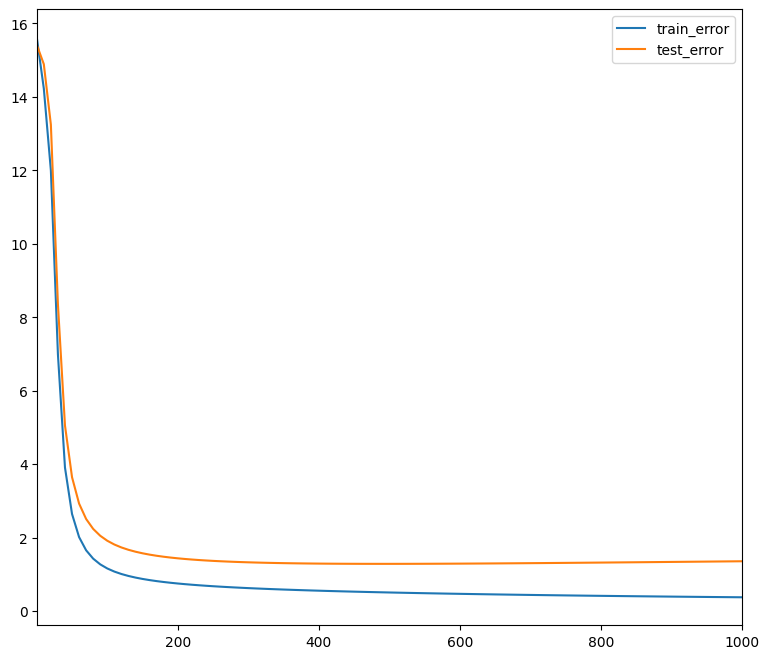

In [30]:
model = build_model(ratings, embedding_dims=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10)

# **MEASURE SIMILARITY**

In [31]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, metric=DOT):
  u = query_embedding
  V = item_embeddings

  if metric == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)

  scores = V.dot(u.T)

  return scores


# **INFERENCE**

In [32]:
def user_recommendations(model, measure=DOT, exclude_rated=True, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings['user_id'][942],
        model.embeddings['movie_id'],
        measure
    )
    score_key = measure + ' score'

    df = pd.DataFrame({
       score_key : list(scores),
        'movie_id' : movies['movie_id'],
        'title' : movies['title'],
        'genre' : movies['all_genres'],
    })

  if exclude_rated:
    rated_movies = ratings[ratings.user_id == "942"]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]



  display.display(df.sort_values(score_key, ascending=False).head(k))

In [33]:
USER_RATINGS=True
user_recommendations(model, measure=DOT, k=6)
user_recommendations(model, measure=COSINE, k=6)

,dot score,movie_id,title,genre
206,6.236,206,Cyrano de Bergerac (1990),Action-Drama-Romance
693,6.094,693,Persuasion (1995),Romance
318,6.060,318,Everyone Says I Love You (1996),Comedy-Musical-Romance
866,5.978,866,"Whole Wide World, The (1996)",Drama
1102,5.857,1102,Trust (1990),Comedy-Drama
42,5.737,42,Disclosure (1994),Drama-Thriller


,cosine score,movie_id,title,genre
287,0.671,287,Scream (1996),Horror-Thriller
602,0.650,602,Rear Window (1954),Mystery-Thriller
819,0.647,819,Space Jam (1996),Adventure-Animation-Children-Comedy-Fantasy
526,0.627,526,Gandhi (1982),Drama
471,0.626,471,Dragonheart (1996),Action-Adventure-Fantasy
832,0.614,832,Bulletproof (1996),Action


In [34]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Mencari film berdasarkan judul yang dimasukkan.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))


In [35]:
movie_neighbors(model, "fast", DOT)
movie_neighbors(model, "fast", COSINE)


Nearest neighbors of : Breakfast at Tiffany's (1961).


,dot score,titles,genres
130,11.581,Breakfast at Tiffany's (1961),Drama-Romance
557,8.129,Heavenly Creatures (1994),Drama-Fantasy-Thriller
13,7.522,"Postino, Il (1994)",Drama-Romance
612,7.469,My Man Godfrey (1936),Comedy
18,7.205,Antonia's Line (1995),Drama
427,6.754,Harold and Maude (1971),Comedy


Nearest neighbors of : Breakfast at Tiffany's (1961).


,cosine score,titles,genres
130,1.000,Breakfast at Tiffany's (1961),Drama-Romance
13,0.739,"Postino, Il (1994)",Drama-Romance
557,0.681,Heavenly Creatures (1994),Drama-Fantasy-Thriller
18,0.671,Antonia's Line (1995),Drama
492,0.666,"Thin Man, The (1934)",Mystery
161,0.661,On Golden Pond (1981),Drama
